#### CUSUM Method
> The purpose of this notebook is to explore the CUSUM algorithm and use it on a sample dataset to better understand it's implementation. I am going to use July through October daily-high-temperature data for Atlanta from 1996 through 2015 to identify when unofficial summer ends (i.e., when the weather starts cooling off) each year and see if it is changing. I am also going to look at whether Atlanta’s summer climate has gotten warmer in that time (and if so, when).

In [32]:
# Load libraries needed for analysis
library(pastecs)
library(ggplot2)
library(dplyr)

#### Part 1 - Unofficial Summer End
The first part of this problem involves applying the CUSUM method to the daily temperatures to see if their is a definitive drop in temperatures that would indicate the end of summer. Their is a CUSUM package in R but I am going to do it by hand to get better practice and deeper understanding of the model. To do this I am going to go through the following steps:
1) Review the data to get a better understanding of its characterstics
2) Compute the average temperature for each day across all years
3) Determine the mean temperature and the model parameters T and C
4) Compute the cumulative sum St
5) Interpret the results

#### Step 1 - Review the Data

In [23]:
# Load the data
temps_data <- read.table("temps.txt", header = TRUE)
temps_data$DAY <- factor(temps_data$DAY, levels = temps_data$DAY)

In [24]:
# Look at the data, only displaying the first 6 rows for this report
head(temps_data)

DAY,X1996,X1997,X1998,X1999,X2000,X2001,X2002,X2003,X2004,...,X2006,X2007,X2008,X2009,X2010,X2011,X2012,X2013,X2014,X2015
1-Jul,98,86,91,84,89,84,90,73,82,...,93,95,85,95,87,92,105,82,90,85
2-Jul,97,90,88,82,91,87,90,81,81,...,93,85,87,90,84,94,93,85,93,87
3-Jul,97,93,91,87,93,87,87,87,86,...,93,82,91,89,83,95,99,76,87,79
4-Jul,90,91,91,88,95,84,89,86,88,...,91,86,90,91,85,92,98,77,84,85
5-Jul,89,84,91,90,96,86,93,80,90,...,90,88,88,80,88,90,100,83,86,84
6-Jul,93,84,89,91,96,87,93,84,90,...,81,87,82,87,89,90,98,83,87,84


In [25]:
# Look at the data types
t(sapply(temps_data, class))

DAY,X1996,X1997,X1998,X1999,X2000,X2001,X2002,X2003,X2004,...,X2006,X2007,X2008,X2009,X2010,X2011,X2012,X2013,X2014,X2015
factor,integer,integer,integer,integer,integer,integer,integer,integer,integer,...,integer,integer,integer,integer,integer,integer,integer,integer,integer,integer


In [26]:
# Double check size of the data
cat('Rows',' ','Columns')
t(dim(temps_data))

Rows   Columns

123,21


In [27]:
# Get statistical information
stat.desc(temps_data)

,DAY,X1996,X1997,X1998,X1999,X2000,X2001,X2002,X2003,X2004,...,X2006,X2007,X2008,X2009,X2010,X2011,X2012,X2013,X2014,X2015
nbr.val,NA,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,...,1.230000e+02,1.230000e+02,1.230000e+02,123.0000000,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02,1.230000e+02
nbr.null,NA,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
nbr.na,NA,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
min,NA,6.000000e+01,5.500000e+01,6.300000e+01,5.700000e+01,5.500000e+01,5.100000e+01,5.700000e+01,5.700000e+01,6.200000e+01,...,5.300000e+01,5.900000e+01,5.000000e+01,51.0000000,6.700000e+01,5.900000e+01,5.600000e+01,5.600000e+01,6.300000e+01,5.600000e+01
max,NA,9.900000e+01,9.500000e+01,9.500000e+01,9.900000e+01,1.010000e+02,9.300000e+01,9.700000e+01,9.100000e+01,9.500000e+01,...,9.800000e+01,1.040000e+02,9.500000e+01,95.0000000,9.700000e+01,9.900000e+01,1.050000e+02,9.200000e+01,9.500000e+01,9.700000e+01
range,NA,3.900000e+01,4.000000e+01,3.200000e+01,4.200000e+01,4.600000e+01,4.200000e+01,4.000000e+01,3.400000e+01,3.300000e+01,...,4.500000e+01,4.500000e+01,4.500000e+01,44.0000000,3.000000e+01,4.000000e+01,4.900000e+01,3.600000e+01,3.200000e+01,4.100000e+01
sum,NA,1.029700e+04,1.004600e+04,1.036400e+04,1.025300e+04,1.033600e+04,1.003100e+04,1.028100e+04,1.002200e+04,1.005700e+04,...,1.021500e+04,1.050400e+04,1.014900e+04,9962.0000000,1.072700e+04,1.048900e+04,1.041200e+04,1.004500e+04,1.032500e+04,1.024600e+04
median,NA,8.400000e+01,8.400000e+01,8.600000e+01,8.600000e+01,8.600000e+01,8.400000e+01,8.700000e+01,8.400000e+01,8.200000e+01,...,8.500000e+01,8.600000e+01,8.500000e+01,83.0000000,9.000000e+01,8.900000e+01,8.500000e+01,8.400000e+01,8.600000e+01,8.500000e+01
mean,NA,8.371545e+01,8.167480e+01,8.426016e+01,8.335772e+01,8.403252e+01,8.155285e+01,8.358537e+01,8.147967e+01,8.176423e+01,...,8.304878e+01,8.539837e+01,8.251220e+01,80.9918699,8.721138e+01,8.527642e+01,8.465041e+01,8.166667e+01,8.394309e+01,8.330081e+01
SE.mean,NA,7.707778e-01,8.402680e-01,5.779084e-01,8.767230e-01,8.582715e-01,7.415797e-01,8.499223e-01,6.327873e-01,6.007771e-01,...,8.830639e-01,8.145141e-01,7.874436e-01,0.8126922,6.713072e-01,8.954623e-01,8.342578e-01,6.966788e-01,5.943334e-01,7.852885e-01


This lets me know that I have a table with 123 rows and 21 columns. The data is primarily integers with one factor value which is the DAY column. Temperature ranges for each year are ~30-40 degrees and the standard deviations are ~6.5-10. The data represents the daily high temperature for the given year.

#### Step 2 - Compute the average temperature for each day
Next I am going to compute the average temperature for each day across all the years in the column and then add that value to the original dataset

In [28]:
# Compute the average temperature for each day of the year
date_average <- rowMeans(temps_data[,2:21])

# Add the values to the orginal dataset
temps_data$AVERAGE <- date_average

# Look at the updated table
head(temps_data)

DAY,X1996,X1997,X1998,X1999,X2000,X2001,X2002,X2003,X2004,...,X2007,X2008,X2009,X2010,X2011,X2012,X2013,X2014,X2015,AVERAGE
1-Jul,98,86,91,84,89,84,90,73,82,...,95,85,95,87,92,105,82,90,85,88.85
2-Jul,97,90,88,82,91,87,90,81,81,...,85,87,90,84,94,93,85,93,87,88.35
3-Jul,97,93,91,87,93,87,87,87,86,...,82,91,89,83,95,99,76,87,79,88.40
4-Jul,90,91,91,88,95,84,89,86,88,...,86,90,91,85,92,98,77,84,85,88.35
5-Jul,89,84,91,90,96,86,93,80,90,...,88,88,80,88,90,100,83,86,84,88.25
6-Jul,93,84,89,91,96,87,93,84,90,...,87,82,87,89,90,98,83,87,84,87.85


#### Step 3 - Determine the mean temperature and the model parameters T and C
To calculate the mean temperature it is supposed to the mean "if no change". This is difficult to determine for the temperature data since we see large changes throughout the summer months as things get hotter and then cool off again. Since we are insterested in summer I choose to use the mean as being the temperatures from July 1st to August 30th. These days have averages above 85 and are close to what is considered summer. The T and C values I set equal to a factor of the standard deviation for those months and played around with different values until I felt like the results were reasonable. Without a better idea of what the model woud be used for and the cost of a false prediction or missing a prediction it is hard to determine the best option.

In [8]:
# Calculate the mean of all of the days
mean_cutoff <- which(temps_data$DAY == '6-Sep')
temp_mean <- mean(temps_data$AVERAGE[1:mean_cutoff])
cat("Mean temperatue is:", temp_mean)

Mean temperatue is: 88.40221

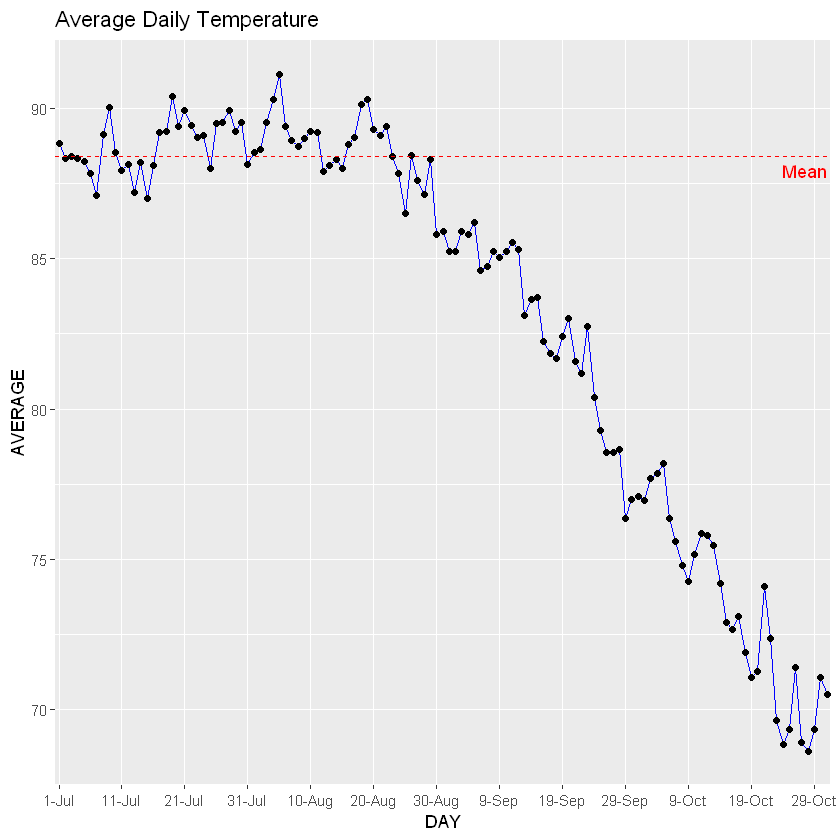

In [9]:
# Plot the average temperature vs. day
ggplot(data=temps_data, aes(x=DAY, y=AVERAGE, group = 1)) + 
    geom_line(color='blue') +
    geom_point() +
    ggtitle("Average Daily Temperature") +
    geom_hline(yintercept = temp_mean, linetype = "dashed", color = "red") +
    annotate("text", x = Inf, y = temp_mean, label = "Mean Value", vjust = 1.5, color = "red") +
    scale_x_discrete(breaks = temps_data$DAY[seq(1, nrow(temps_data), 10)])

In [10]:
# Set T and C values
T <- 5 * sd(temps_data$AVERAGE[1:mean_cutoff])
C <- .5 * sd(temps_data$AVERAGE[1:mean_cutoff])

#### Step 4 - Compute the cumulative sum (St)
Next I am going to compute the daily St and running total. Since I am detecting a decrease I am using the model where the daily value and C are subtracted from the mean.

In [11]:
# Calculate difference between average temperature for each day the mean and C value
S_t_row <- temp_mean - date_average - C
temps_data$S_t_row <- S_t_row
head(temps_data)

DAY,X1996,X1997,X1998,X1999,X2000,X2001,X2002,X2003,X2004,...,X2008,X2009,X2010,X2011,X2012,X2013,X2014,X2015,AVERAGE,S_t_row
1-Jul,98,86,91,84,89,84,90,73,82,...,85,95,87,92,105,82,90,85,88.85,-1.1290248
2-Jul,97,90,88,82,91,87,90,81,81,...,87,90,84,94,93,85,93,87,88.35,-0.6290248
3-Jul,97,93,91,87,93,87,87,87,86,...,91,89,83,95,99,76,87,79,88.40,-0.6790248
4-Jul,90,91,91,88,95,84,89,86,88,...,90,91,85,92,98,77,84,85,88.35,-0.6290248
5-Jul,89,84,91,90,96,86,93,80,90,...,88,80,88,90,100,83,86,84,88.25,-0.5290248
6-Jul,93,84,89,91,96,87,93,84,90,...,82,87,89,90,98,83,87,84,87.85,-0.1290248


In [12]:
# Initialize an empty vector filled with zeros
S_t_running <- numeric(nrow(temps_data))

# Loop through each row and get the running sum of S_t values
for (i in 1:nrow(temps_data)) {
    if (i == 1) {
        previous_value <- 0
    } else {
        previous_value <- S_t_running[i-1]
    }
    S_t_running[i] <- pmax(0, previous_value + temps_data$S_t_row[i])
}

temps_data$S_t_running <- S_t_running
head(temps_data)

DAY,X1996,X1997,X1998,X1999,X2000,X2001,X2002,X2003,X2004,...,X2009,X2010,X2011,X2012,X2013,X2014,X2015,AVERAGE,S_t_row,S_t_running
1-Jul,98,86,91,84,89,84,90,73,82,...,95,87,92,105,82,90,85,88.85,-1.1290248,0
2-Jul,97,90,88,82,91,87,90,81,81,...,90,84,94,93,85,93,87,88.35,-0.6290248,0
3-Jul,97,93,91,87,93,87,87,87,86,...,89,83,95,99,76,87,79,88.40,-0.6790248,0
4-Jul,90,91,91,88,95,84,89,86,88,...,91,85,92,98,77,84,85,88.35,-0.6290248,0
5-Jul,89,84,91,90,96,86,93,80,90,...,80,88,90,100,83,86,84,88.25,-0.5290248,0
6-Jul,93,84,89,91,96,87,93,84,90,...,87,89,90,98,83,87,84,87.85,-0.1290248,0


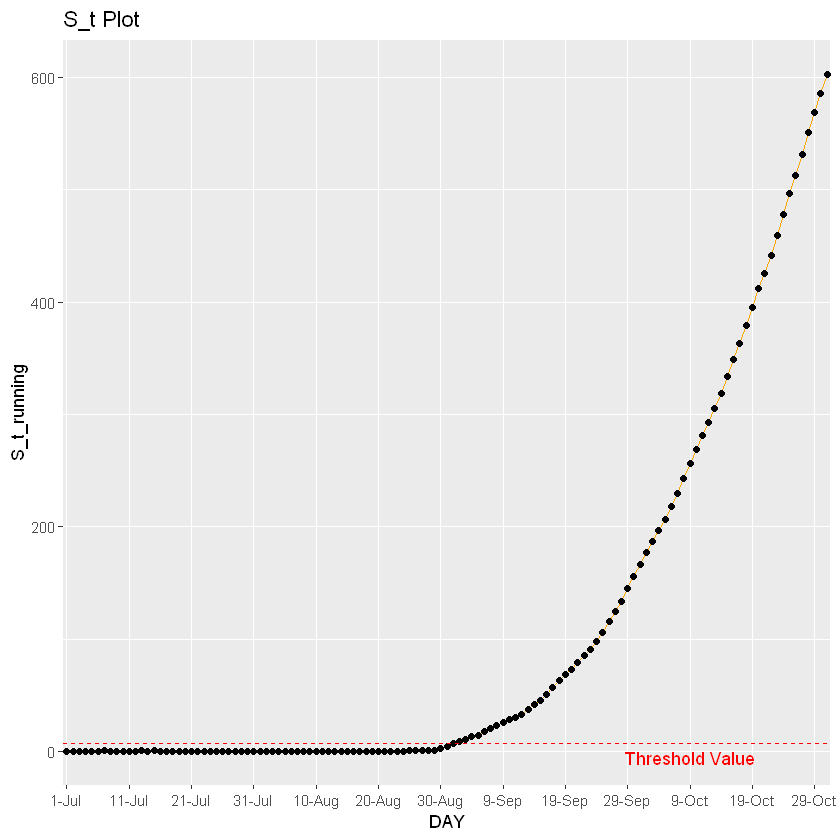

In [13]:
# Plot the results
ggplot(data=temps_data, aes(x=DAY, y=S_t_running, group = 1)) + 
    geom_line(color='orange') +
    geom_point() +
    ggtitle("S_t Plot") +
    scale_x_discrete(breaks = temps_data$DAY[seq(1, length(temps_data$DAY), by = 10)]) +
    geom_hline(yintercept = T, linetype = "dashed", color = "red") +
    annotate("text", x = '9-Oct', y = T, label = "Threshold Value", vjust = 1.5, color = "red")

#### Step 5 - Analyze the Results
Based on the information provided by the CUSUM method, unnoficial summer ends **September 1st**. Looking at the original temperature data it does show that around that time the temperatures begin to decline so this makes sense.

In [14]:
# First value to cross threshold
crossed_value_index <- min(which(temps_data$S_t_running >= T))
cat("Unofficial summer ends on", as.character(temps_data$DAY[crossed_value_index]), "with a temerature of", temps_data$AVERAGE[crossed_value_index], "degrees Farenheit")

Unofficial summer ends on 1-Sep with a temerature of 85.25 degrees Farenheit

#### Part 2 - Change in Avgerage Temperature
The second part of this analysis is to apply the CUSUM method to the yearly temperatures to see if their is a change in yearly average temperatures. To do this I am going to go through the following steps:
1) Compute the average temperature for each year across all days
2) Determine the mean temperature and the model parameters T and C
3) Compute the cumulative sum St
4) Interpret the results

#### Step 1 - Computer the Average Temperature for each Year
I am going to compute the average temperature for each year across all of the days provided, another approach would be to just compute the average for the months considered summer to see if their is a change there. I think both approaches would make sense but since the initial question asks if their is a yearly average change I'm using the whole dataset.

In [29]:
# Compute the average temperature for year
year_average <- colMeans(temps_data[, 2:21])
years <- sub("X", "", names(year_average))
yearly_average_table <- tibble(
    Year = years,
    Average_Temp = year_average
)
yearly_average_table

Year,Average_Temp
1996,83.71545
1997,81.67480
1998,84.26016
1999,83.35772
2000,84.03252
2001,81.55285
2002,83.58537
2003,81.47967
2004,81.76423
2005,83.35772


`geom_smooth()` using formula 'y ~ x'


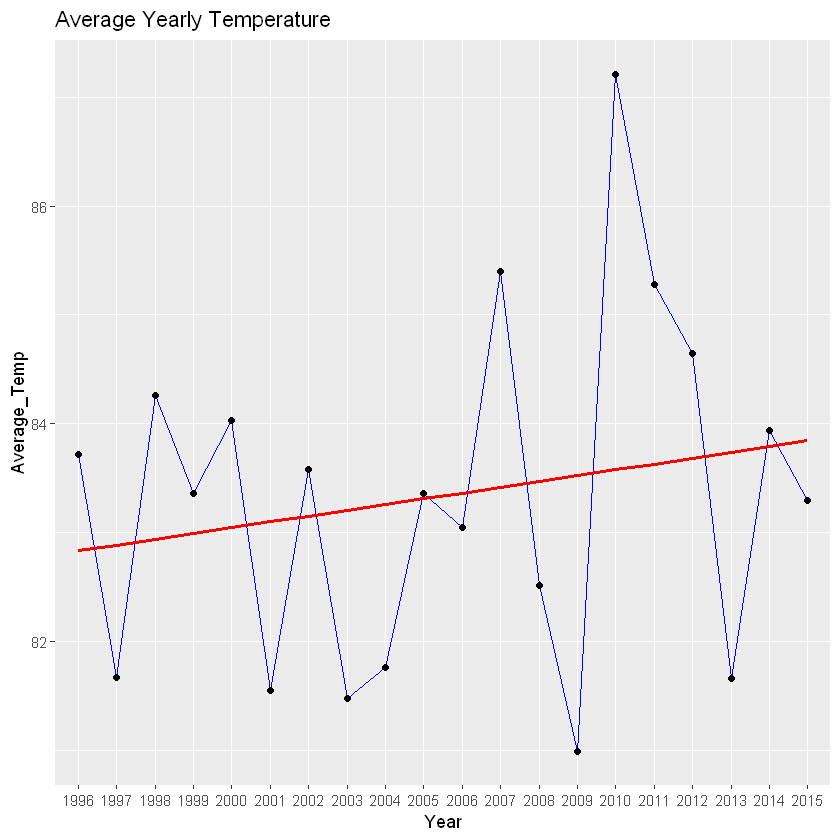

In [30]:
# Plot the average temperature vs. year
ggplot(data=yearly_average_table, aes(x=Year, y=Average_Temp, group = 1)) + 
    geom_line(color='blue') +
    geom_point() +
    ggtitle("Average Yearly Temperature") +
    geom_smooth(method = "lm", se = FALSE, color = "red")

#### Step 2 - Determine the mean temperature and the model parameters T and C
Next I am going to compute the mean "if not change", looking at the graph above temperatures seem to stay consistent through 2006 then start to vary more drastically. As a result I am going to use the mean from 1996 to 2006. For the T and C values I set them to a factor of the standard deviation and played around with different values until the results seemed reasonable.

In [31]:
# Calculate the mean for the control period (1996 - 2006)
yearly_mean <- mean(yearly_average_table$Average_Temp[1:11])
cat("Mean yearly temperatue is:", yearly_mean)

# Set T and C values
T_yearly <- 4 * sd(yearly_average_table$Average_Temp[1:11])
C_yearly <- 0.5 * sd(yearly_average_table$Average_Temp[1:11])
cat("\n")
cat("T value is:", T_yearly)
cat("\n")
cat("C value is:", C_yearly)

Mean yearly temperatue is: 82.89357
T value is: 4.257939
C value is: 0.5322424

#### Step 4 - Compute the cumulative sum (St)
Next I am going to compute the yearly values and cumulative sum (St)

In [18]:
# Calculate difference between average temperature for each year the mean and C value
S_t_year <- yearly_average_table$Average_Temp - yearly_mean - C_yearly
yearly_average_table$S_t_row <- S_t_year
head(yearly_average_table)

Year,Average_Temp,S_t_row
1996,83.71545,0.28963492
1997,81.67480,-1.75101548
1998,84.26016,0.83435037
1999,83.35772,-0.06808865
2000,84.03252,0.60670809
2001,81.55285,-1.87296670


In [19]:
# Initialize an empty vector filled with zeros
S_t_year_running <- numeric(nrow(yearly_average_table))

# Loop through each row and get the running sum of S_t values
for (i in 1:nrow(yearly_average_table)) {
    if (i == 1) {
        previous_value <- 0
    } else {
        previous_value <- S_t_year_running[i-1]
    }
    S_t_year_running[i] <- pmax(0, previous_value + yearly_average_table$S_t_row[i])
}

yearly_average_table$S_t_running <- S_t_year_running
head(yearly_average_table)

Year,Average_Temp,S_t_row,S_t_running
1996,83.71545,0.28963492,0.2896349
1997,81.67480,-1.75101548,0.0000000
1998,84.26016,0.83435037,0.8343504
1999,83.35772,-0.06808865,0.7662617
2000,84.03252,0.60670809,1.3729698
2001,81.55285,-1.87296670,0.0000000


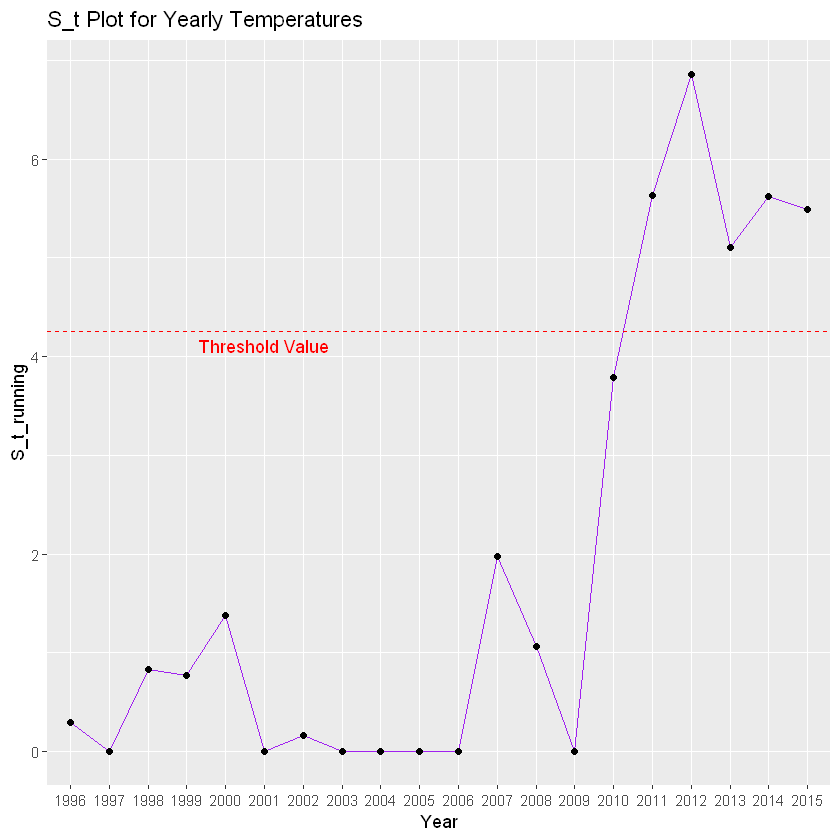

In [20]:
ggplot(data=yearly_average_table, aes(x=Year, y=S_t_running, group = 1)) + 
    geom_line(color='purple') +
    geom_point() +
    ggtitle("S_t Plot for Yearly Temperatures") +
    geom_hline(yintercept = T_yearly, linetype = "dashed", color = "red") +
    annotate("text", x = '2001', y = T_yearly, label = "Threshold Value", vjust = 1.5, color = "red")

#### Step 4 - Analyze the Results
Based on the CUSUM model it can be seen that the yearly average temperature starts to increase around 2010/2011. This would indicate general warming of temperatures around that time. Based on the threshold value I set we can say that temperatures begin to rise in 2011. **However, by simply changing the threshold value I can pretty much get the model to tell me whatever I want it to, I can show no change or an earlier change. It is very easy to assume that we should be seeing a change due to global warming and ensure our model shows that. This is a great example of why it is important to keep biases from entering into the model development.**

In [21]:
# First value to cross threshold
crossed_yearly_index <- min(which(yearly_average_table$S_t_running >= T_yearly))
cat("Yearly temperatures begin to rise",yearly_average_table$Year[crossed_yearly_index], "with an average temerature of", yearly_average_table$Average_Temp[crossed_yearly_index], "degrees Farenheit")

Yearly temperatures begin to rise 2011 with an average temerature of 85.27642 degrees Farenheit